# Home Credit Default Risk - Machine Learning Project

## Project Overview
- Predict loan default risk using historical credit data.
- Objectives: Improve financial risk assessment, reduce losses for lenders.

# Processing `bureau_balance.csv` (Credit Bureau Loan History)

## 1. Load Data (`bureau_balance.csv`)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
# Load dataset 
df_bureau_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau_balance.csv")

## 2. Initial Data Inspection (`bureau_balance.csv`)

In [3]:
# Check for infinite values
print("🔍 Checking for infinite values in dataset...")
inf_count = (df_bureau_balance == np.inf).sum().sum()
neg_inf_count = (df_bureau_balance == -np.inf).sum().sum()

if inf_count > 0 or neg_inf_count > 0:
    print(f"⚠️ Found {inf_count} positive and {neg_inf_count} negative infinite values!")
else:
    print("✅ No infinite values detected.")

🔍 Checking for infinite values in dataset...
✅ No infinite values detected.


In [4]:
# 🔍 Check for missing values
missing_values = df_bureau_balance.isnull().sum()
missing_values = missing_values[missing_values > 0]  

if not missing_values.empty:
    print("⚠️ Missing values detected in columns:")
    print(missing_values)
else:
    print("✅ No missing values detected.")

✅ No missing values detected.


In [11]:
print(df_bureau_balance.columns)

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')


In [12]:
# Check for extreme values using percentile-based thresholds 
print("🔍 Checking for extreme values in 'bureau_balance' dataset using percentile thresholds...")

# Exclude ID columns from percentile-based detection
extreme_exclude_cols = ['SK_ID_BUREAU'] 
extreme_numeric_columns = df_bureau_balance.select_dtypes(include=["number"]).drop(columns=extreme_exclude_cols, errors='ignore')

# Compute percentile-based thresholds
extreme_upper_threshold = extreme_numeric_columns.quantile(0.99)
extreme_lower_threshold = extreme_numeric_columns.quantile(0.01)

# Identify extreme values
extreme_large_columns = extreme_numeric_columns.max() > extreme_upper_threshold
extreme_small_columns = extreme_numeric_columns.min() < extreme_lower_threshold

# Print results
if extreme_large_columns.any():
    print(f"⚠️ Columns with very large values (above 99th percentile):\n{extreme_numeric_columns.loc[:, extreme_large_columns].max()}")
if extreme_small_columns.any():
    print(f"⚠️ Columns with very small values (below 1st percentile):\n{extreme_numeric_columns.loc[:, extreme_small_columns].min()}")
if not extreme_large_columns.any() and not extreme_small_columns.any():
    print("✅ No extreme values detected in 'bureau_balance' dataset.")


🔍 Checking for extreme values in 'bureau_balance' dataset using percentile thresholds...
⚠️ Columns with very small values (below 1st percentile):
MONTHS_BALANCE   -96
dtype: int64


In [7]:
# Check the shape of the dataset
print("DataFrame Shape:", df_bureau_balance.shape)

DataFrame Shape: (27299925, 3)


In [8]:
# Display the first few rows
print("First few rows of bureau_balance DataFrame:")
display(df_bureau_balance.head())

First few rows of bureau_balance DataFrame:


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [9]:
# Get a concise summary of the DataFrame
print("\nDataFrame Info:")
df_bureau_balance.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [14]:
# Get summary statistics of columns
print("\nDescriptive Statistics:")
display(df_bureau_balance.describe())
display(df_bureau_balance.describe(include="object"))


Descriptive Statistics:


,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


,STATUS
count,27299925
unique,8
top,C
freq,13646993


In [15]:
# To see all values in STATUS
print(df_bureau_balance["STATUS"].unique())

['C' '0' 'X' '1' '2' '3' '5' '4']


In [16]:
# To count how often each value appears
print(df_bureau_balance["STATUS"].value_counts())

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64


## 3. Initial Data Cleaning (`bureau_balance.csv`)

In [17]:
# Replace infinite values with NaN before handling missing values
df_bureau_balance.replace([np.inf, -np.inf], np.nan, inplace=True)
print("✅ Infinite values replaced with NaN.")

✅ Infinite values replaced with NaN.


In [18]:
# Convert manually identified categorical columns
categorical_cols = ["STATUS"]
df_bureau_balance[categorical_cols] = df_bureau_balance[categorical_cols].astype("category")

print("✅ Converted manually identified categorical columns to 'category'.")

✅ Converted manually identified categorical columns to 'category'.


In [19]:
# Check unique values in categorical columns
print("🔍 Unique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df_bureau_balance[col].nunique()} unique values")

🔍 Unique values in categorical columns:
STATUS: 8 unique values


In [20]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types:")
print(df_bureau_balance.dtypes)
pd.reset_option('display.max_rows')  

✅ Updated Data Types:
SK_ID_BUREAU         int64
MONTHS_BALANCE       int64
STATUS            category
dtype: object


### Missing Values Handling

In [21]:
# Check for missing values
pd.set_option('display.max_rows', None) 
print("🔍 Missing values in each column:")
print(df_bureau_balance.isnull().sum())
pd.reset_option('display.max_rows')  

🔍 Missing values in each column:
SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


In [22]:
# Check for duplicates
print("Number of duplicate rows:", df_bureau_balance.duplicated().sum())

Number of duplicate rows: 0


## 4. Exploratory Data Analysis (`bureau_balance.csv`)

In [23]:
### Summary Statistics
pd.set_option('display.max_columns', None)

# Numeric summary
print("Summary Statistics (Numeric Features):")
display(df_bureau_balance.describe().T)

# Categorical summary
print("Summary Statistics (Categorical Features):")
display(df_bureau_balance.describe(include=["category"]).T)

pd.reset_option('display.max_columns')

Summary Statistics (Numeric Features):


,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,27299925.0,6.036297e+06,492348.856904,5001709.0,5730933.0,6070821.0,6431951.0,6842888.0
MONTHS_BALANCE,27299925.0,-3.074169e+01,23.864509,-96.0,-46.0,-25.0,-11.0,0.0


Summary Statistics (Categorical Features):


,count,unique,top,freq
STATUS,27299925,8,C,13646993


### 4.1 Correlation Analysis (`bureau_balance.csv`)

Correlation analysis is skipped because bureau_balance.csv contains only one numeric feature (MONTHS_BALANCE), making correlation analysis and heatmaps irrelevant.

### 4.2 Visualising Outliers (`bureau_balance.csv`)

Outlier detection is skipped because `bureau_balance.csv` does not contain traditional transactional numeric features.  
The only numeric column, `MONTHS_BALANCE`, represents time-series data, where detecting outliers using boxplots is not meaningful.  
Instead, a histogram of `MONTHS_BALANCE` is included in additional EDA to analyze its distribution.

### 4.3 Pair Plot Analysis (`bureau_balance.csv`)

Pair plot analysis is skipped because `bureau_balance.csv` contains only one numeric feature (`MONTHS_BALANCE`).  
Pair plots are most useful when analyzing relationships between multiple numerical variables, which are not present in this dataset.

### 4.4 Group-wise Analysis (`bureau_balance.csv`)

Group-wise analysis is skipped because `bureau_balance.csv` contains only one categorical feature (`STATUS`).  
Since there are no additional numeric or categorical variables to group by, this analysis does not provide meaningful insights.  
Categorical distributions of `STATUS` will be explored in additional EDA visualizations.

### 4.5 Time-wise Analysis (`bureau_balance.csv`)

In [24]:
# Aggregate STATUS counts per MONTHS_BALANCE
status_trend = df_bureau_balance.groupby(["MONTHS_BALANCE", "STATUS"]).size().reset_index(name="count")

# Display first few rows
status_trend.head()

<ipython-input-24-9d3bcb7c1451>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_trend = df_bureau_balance.groupby(["MONTHS_BALANCE", "STATUS"]).size().reset_index(name="count")


,MONTHS_BALANCE,STATUS,count
0,-96,0,18250
1,-96,1,595
2,-96,2,100
3,-96,3,38
4,-96,4,27


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pa

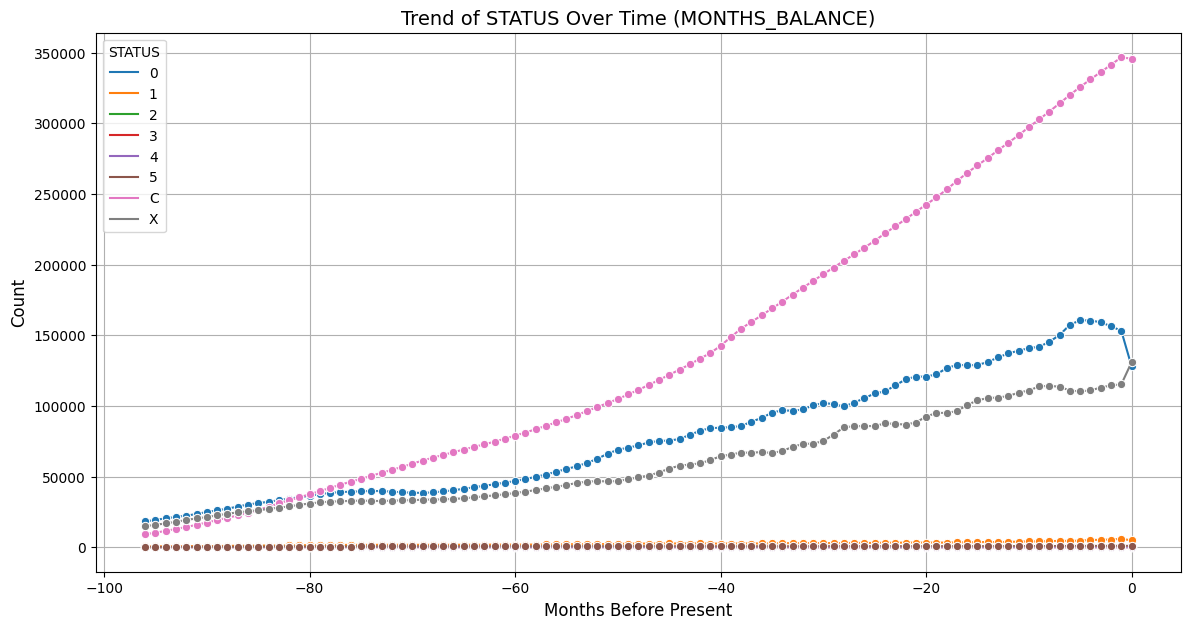

In [25]:
# Set figure size
plt.figure(figsize=(14, 7))

# Create a line plot for each STATUS category
sns.lineplot(data=status_trend, x="MONTHS_BALANCE", y="count", hue="STATUS", marker="o")

# Titles and labels
plt.title("Trend of STATUS Over Time (MONTHS_BALANCE)", fontsize=14)
plt.xlabel("Months Before Present", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="STATUS")
plt.grid(True)

# Show plot
plt.show()

### 4.6 Joint Plot Analysis (`bureau_balance.csv`)

Joint plot analysis is skipped because `bureau_balance.csv` has only one numeric feature (`MONTHS_BALANCE`).  
Joint plots are typically used to explore relationships between two numerical variables, which are not present in this dataset.

### 4.7 Additional EDA Visualisations (`bureau_balance.csv`)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


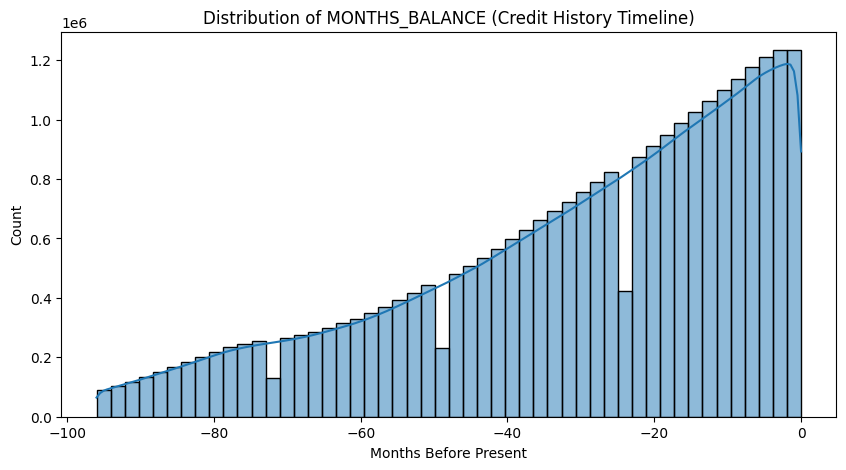

In [26]:
# Plot histogram for MONTHS_BALANCE to see distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_bureau_balance["MONTHS_BALANCE"], bins=50, kde=True)  
plt.title("Distribution of MONTHS_BALANCE (Credit History Timeline)")
plt.xlabel("Months Before Present")
plt.ylabel("Count")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


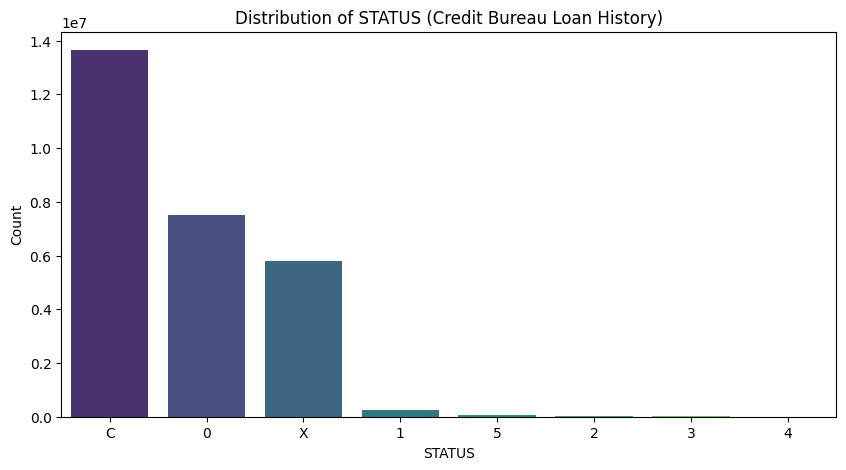

In [27]:
# Plot bar chart for STATUS distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=df_bureau_balance["STATUS"], order=df_bureau_balance["STATUS"].value_counts().index, palette="viridis")
plt.title("Distribution of STATUS (Credit Bureau Loan History)")
plt.xlabel("STATUS")
plt.ylabel("Count")
plt.show()

## 5. Feature Engineering (`bureau_balance.csv`)

### 5.1 Credit Activity Features (`bureau_balance.csv`)

In [28]:
# Group by SK_ID_BUREAU and calculate credit activity features
bureau_balance_credit_activity = df_bureau_balance.groupby("SK_ID_BUREAU").agg(
    bureau_balance_NUM_MONTHS=("MONTHS_BALANCE", "count"),  # Total active months per loan
    bureau_balance_NUM_CLOSED_MONTHS=("STATUS", lambda x: (x == "C").sum()),  # Count closed loan months
    bureau_balance_NUM_ACTIVE_MONTHS=("STATUS", lambda x: (x == "0").sum()),  # Count active (non-overdue) months
    bureau_balance_NUM_OVERDUE_MONTHS=("STATUS", lambda x: x.isin(["1", "2", "3", "4", "5"]).sum()),  # Overdue counts
).reset_index()

# Preview the new features before merging
display(bureau_balance_credit_activity.head())

,SK_ID_BUREAU,bureau_balance_NUM_MONTHS,bureau_balance_NUM_CLOSED_MONTHS,bureau_balance_NUM_ACTIVE_MONTHS,bureau_balance_NUM_OVERDUE_MONTHS
0,5001709,97,86,0,0
1,5001710,83,48,5,0
2,5001711,4,0,3,0
3,5001712,19,9,10,0
4,5001713,22,0,0,0


### 5.2 Time-Based Features (`bureau_balance.csv`)

In [29]:
# Group by SK_ID_BUREAU and calculate time-related statistics
bureau_balance_time_features = df_bureau_balance.groupby("SK_ID_BUREAU").agg(
    bureau_balance_OLDEST_RECORD=("MONTHS_BALANCE", "min"),  # Earliest recorded month for the loan
    bureau_balance_MOST_RECENT_RECORD=("MONTHS_BALANCE", "max"),  # Most recent recorded month for the loan
    bureau_balance_CREDIT_HISTORY_LENGTH=("MONTHS_BALANCE", lambda x: x.max() - x.min()),  # Length of recorded history
).reset_index()

# Preview the new features before merging
display(bureau_balance_time_features.head())

,SK_ID_BUREAU,bureau_balance_OLDEST_RECORD,bureau_balance_MOST_RECENT_RECORD,bureau_balance_CREDIT_HISTORY_LENGTH
0,5001709,-96,0,96
1,5001710,-82,0,82
2,5001711,-3,0,3
3,5001712,-18,0,18
4,5001713,-21,0,21


### 5.3 Credit Overdue Features (`bureau_balance.csv`)

In [31]:
# Define the correct order of STATUS categories
status_order = ["0", "1", "2", "3", "4", "5", "C", "X"]  # Ordered from least to most overdue

# Convert STATUS to an ordered categorical variable
df_bureau_balance["STATUS"] = pd.Categorical(df_bureau_balance["STATUS"], categories=status_order, ordered=True)

# Group by SK_ID_BUREAU and calculate overdue-related statistics
bureau_balance_overdue_features = df_bureau_balance.groupby("SK_ID_BUREAU").agg(
    bureau_balance_NUM_OVERDUE_MONTHS=("STATUS", lambda x: x.isin(["1", "2", "3", "4", "5"]).sum()),  # Total overdue months
    bureau_balance_MAX_OVERDUE_STATUS=("STATUS", lambda x: x[x.isin(["1", "2", "3", "4", "5"])].max() if x.isin(["1", "2", "3", "4", "5"]).any() else "0")  # Max overdue level
).reset_index()

# Preview the new features before merging
display(bureau_balance_overdue_features.head())

,SK_ID_BUREAU,bureau_balance_NUM_OVERDUE_MONTHS,bureau_balance_MAX_OVERDUE_STATUS
0,5001709,0,0
1,5001710,0,0
2,5001711,0,0
3,5001712,0,0
4,5001713,0,0


### 5.4 Categorical Features Aggregation (`bureau_balance.csv`)

In [33]:
# Group by SK_ID_BUREAU and compute categorical aggregations
bureau_balance_categorical_features = df_bureau_balance.groupby("SK_ID_BUREAU").agg(
    bureau_balance_PERCENT_CLOSED=("STATUS", lambda x: (x == "C").sum() / len(x)),  # % of months loan was closed
    bureau_balance_PERCENT_ACTIVE=("STATUS", lambda x: (x == "0").sum() / len(x)),  # % of months loan was active
    bureau_balance_MOST_COMMON_STATUS=("STATUS", lambda x: x.mode()[0] if not x.mode().empty else "Unknown")  # Most frequent status
).reset_index()

# Preview the new features before merging
display(bureau_balance_categorical_features.head())

,SK_ID_BUREAU,bureau_balance_PERCENT_CLOSED,bureau_balance_PERCENT_ACTIVE,bureau_balance_MOST_COMMON_STATUS
0,5001709,0.886598,0.000000,C
1,5001710,0.578313,0.060241,C
2,5001711,0.000000,0.750000,0
3,5001712,0.473684,0.526316,0
4,5001713,0.000000,0.000000,X


## 6. Aggregation (`bureau_balance.csv`)

### 6.1 Aggregate All Numeric and Categorical Columns (`bureau_balance.csv`)

In [39]:
# 🔹 Aggregate df_bureau_balance before merging
print("\n🔄 Aggregating df_bureau_balance by SK_ID_BUREAU...")

# Select numerical columns (keep SK_ID_BUREAU for grouping)
agg_numeric_columns = df_bureau_balance.select_dtypes(include=['number'])

# 🔹 Aggregate numerical features (without std for consistency)
agg_funcs = ['mean', 'sum', 'max', 'min']
agg_numeric = agg_numeric_columns.groupby('SK_ID_BUREAU').agg(agg_funcs)

# Rename columns to avoid multi-index issue
agg_numeric.columns = ['bureau_balance_agg_' + '_'.join(col) for col in agg_numeric.columns]
agg_numeric.reset_index(inplace=True)

# 🔹 Optimize categorical feature aggregation
agg_categorical_columns = df_bureau_balance.select_dtypes(include=['object', 'category']).drop(columns=['SK_ID_BUREAU'], errors='ignore')

if not agg_categorical_columns.empty:
    # Instead of mode(), use value_counts().idxmax() for speed
    agg_categorical_columns = df_bureau_balance[['SK_ID_BUREAU']].join(agg_categorical_columns)
    
    agg_categorical = agg_categorical_columns.groupby('SK_ID_BUREAU').agg(lambda x: x.value_counts().idxmax() if not x.empty else "Unknown")
    agg_categorical.columns = ['bureau_balance_agg_' + col + '_most_frequent' for col in agg_categorical.columns]
    agg_categorical.reset_index(inplace=True)

    # Merge aggregated numerical and categorical features
    df_bureau_balance_aggregated = agg_numeric.merge(agg_categorical, on="SK_ID_BUREAU", how="left")
else:
    df_bureau_balance_aggregated = agg_numeric

# Check new shape
print(f"✅ Aggregation complete. New df_bureau_balance_aggregated shape: {df_bureau_balance_aggregated.shape}")

# Preview the aggregated dataset
display(df_bureau_balance_aggregated.head())


🔄 Aggregating df_bureau_balance by SK_ID_BUREAU...
✅ Aggregation complete. New df_bureau_balance_aggregated shape: (817395, 6)


,SK_ID_BUREAU,bureau_balance_agg_MONTHS_BALANCE_mean,bureau_balance_agg_MONTHS_BALANCE_sum,bureau_balance_agg_MONTHS_BALANCE_max,bureau_balance_agg_MONTHS_BALANCE_min,bureau_balance_agg_STATUS_most_frequent
0,5001709,-48.0,-4656,0,-96,C
1,5001710,-41.0,-3403,0,-82,C
2,5001711,-1.5,-6,0,-3,0
3,5001712,-9.0,-171,0,-18,0
4,5001713,-10.5,-231,0,-21,X


In [41]:
# 🔍 Checking row count before and after aggregation in bureau_balance notebook
print("Unique Loans in df_bureau_balance:", df_bureau_balance["SK_ID_BUREAU"].nunique())  # Before aggregation
print("Rows in df_bureau_balance_aggregated:", df_bureau_balance_aggregated.shape[0])  # After aggregation

# Preview the structure of the aggregated dataset
print(df_bureau_balance_aggregated.head())

Unique Loans in df_bureau_balance: 817395
Rows in df_bureau_balance_aggregated: 817395
   SK_ID_BUREAU  bureau_balance_agg_MONTHS_BALANCE_mean  \
0       5001709                                   -48.0   
1       5001710                                   -41.0   
2       5001711                                    -1.5   
3       5001712                                    -9.0   
4       5001713                                   -10.5   

   bureau_balance_agg_MONTHS_BALANCE_sum  \
0                                  -4656   
1                                  -3403   
2                                     -6   
3                                   -171   
4                                   -231   

   bureau_balance_agg_MONTHS_BALANCE_max  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   bureau_balance_agg_MONTHS

## 7. Merging (`bureau_balance.csv`)

In [42]:
# Function to safely merge dataframes and print debugging info
def safe_merge(df_main, df_new, merge_on="SK_ID_BUREAU", name=""):
    """ Merges two dataframes and prints sanity checks """
    prev_shape = df_main.shape
    df_main = df_main.merge(df_new, on=merge_on, how="left")

    print(f"✅ Merged {name}: {prev_shape} -> {df_main.shape}")
    print(f"🛠️ Missing Values in {name} After Merge:\n{df_main.isnull().sum()[df_main.isnull().sum() > 0]}")
    print("-" * 50)

    return df_main

# Apply Safe Merges for Bureau Balance
df_bureau_balance_aggregated = safe_merge(df_bureau_balance_aggregated, bureau_balance_credit_activity, name="bureau_balance_credit_activity")
df_bureau_balance_aggregated = safe_merge(df_bureau_balance_aggregated, bureau_balance_time_features, name="bureau_balance_time_features")
df_bureau_balance_aggregated = safe_merge(df_bureau_balance_aggregated, bureau_balance_overdue_features, name="bureau_balance_overdue_features")
df_bureau_balance_aggregated = safe_merge(df_bureau_balance_aggregated, bureau_balance_categorical_features, name="bureau_balance_categorical_features")

print("✅ All bureau_balance feature tables merged successfully!")

✅ Merged bureau_balance_credit_activity: (817395, 6) -> (817395, 10)
🛠️ Missing Values in bureau_balance_credit_activity After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged bureau_balance_time_features: (817395, 10) -> (817395, 13)
🛠️ Missing Values in bureau_balance_time_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged bureau_balance_overdue_features: (817395, 13) -> (817395, 15)
🛠️ Missing Values in bureau_balance_overdue_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged bureau_balance_categorical_features: (817395, 15) -> (817395, 18)
🛠️ Missing Values in bureau_balance_categorical_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ All bureau_balance feature tables merged successfully!


### 7.1 Feature Validation (`bureau_balance.csv`)

In [43]:
# Step 1: Check for standard NaN values after merging
missing_values_bureau_balance = df_bureau_balance_aggregated.isna().sum()
missing_values_bureau_balance = missing_values_bureau_balance[missing_values_bureau_balance > 0]
print("\n🔍 Standard Missing Values in Aggregated Bureau Balance Features After Merging:")
print(missing_values_bureau_balance if not missing_values_bureau_balance.empty else "✅ No standard NaN values detected.")

# Step 2: Check for hidden NaNs (empty strings or "nan" stored as a string) after merging
hidden_nans_bureau_balance = (df_bureau_balance_aggregated == "").sum() + (df_bureau_balance_aggregated == "nan").sum()
hidden_nans_bureau_balance = hidden_nans_bureau_balance[hidden_nans_bureau_balance > 0]
print("\n🔍 Hidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Bureau Balance Features After Merging:")
print(hidden_nans_bureau_balance if not hidden_nans_bureau_balance.empty else "✅ No hidden NaNs detected.")


🔍 Standard Missing Values in Aggregated Bureau Balance Features After Merging:
✅ No standard NaN values detected.

🔍 Hidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Bureau Balance Features After Merging:
✅ No hidden NaNs detected.


In [44]:
# Step 3: Check for Inf values after merging
inf_values_bureau_balance = df_bureau_balance_aggregated.replace([np.inf, -np.inf], np.nan).isna().sum()
inf_values_bureau_balance = inf_values_bureau_balance[inf_values_bureau_balance > 0]

print("\n🔍 Infinite Values in Aggregated Bureau Balance Features After Merging:")
if inf_values_bureau_balance.empty:
    print("✅ No Inf values detected.")
else:
    print(inf_values_bureau_balance)


🔍 Infinite Values in Aggregated Bureau Balance Features After Merging:
✅ No Inf values detected.


In [45]:
# Save the final aggregated bureau balance dataset in CSV and Pickle formats
df_bureau_balance_aggregated.to_csv("bureau_balance_aggregated.csv", index=False)
df_bureau_balance_aggregated.to_pickle("bureau_balance_aggregated.pkl")

print("✅ Bureau balance aggregated dataset saved successfully!")

✅ Bureau balance aggregated dataset saved successfully!
